In [ ]:
#'''
! git clone https://github.com/AndreyYashkin/SPADE-FastAI.git
! pip install -Uqq fastai

from google.colab import drive
drive.mount('/content/drive/')
! cp /content/drive/MyDrive/archive.zip  archive.zip

! mkdir SPADE-FastAI/data
! rm -rf 'SPADE-FastAI/data/ADE20K Outdoors'
! unzip archive.zip -d 'SPADE-FastAI/data/ADE20K Outdoors'
#'''

In [1]:
# Tesla P100-PCIE and Tesla T4 should be fine in colab
! nvidia-smi 

Tue Jun  8 11:28:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%cd SPADE-FastAI

/content/SPADE-FastAI


In [4]:
import os
from fastai.vision.all import *

from src.callblocks import *
from src.cgan import *
from src.data import *
from src.show import *

from src.model.discriminator import *
from src.model.perceptual_loss import *
from src.model.gan_loss import * #gen_hinge_loss, dis_hinge_loss
from src.model.generator import Generator, GenerationSize

In [5]:
def img_to_mask_path(path):
  path = str(path).replace('ADE20K Outdoors/images', 'ADE20K Outdoors/annotations')
  path = path[:-4] + '.png'
  return Path(path)

In [6]:
bs = 30 #32 #30
im_size = GenerationSize.s_128x128
nz = 256
gen_norm = nn.BatchNorm2d
dis_norm = nn.InstanceNorm2d
#epoches = 100 #20#0
lr = 2e-4

class_n = 150 + 1 # +1 is an unknown class
ngf = 64
embedding_dim = 128
ndf = 64
dis_layers = 4

save_to = '/content/drive/MyDrive/SPADE/3'

In [7]:
TensorMask._show_args['cmap'] = 'hsv'

In [8]:
path = 'data/ADE20K Outdoors/images'
batch_tfms = [ToOneHotTransform(class_n), Normalize.from_stats(*gan_stats)]
dls = SpadeDataLoaders.from_mask_path_func(path, img_to_mask_path, nz, bs=bs, item_tfms=Resize(im_size), batch_tfms=batch_tfms, seed=42)

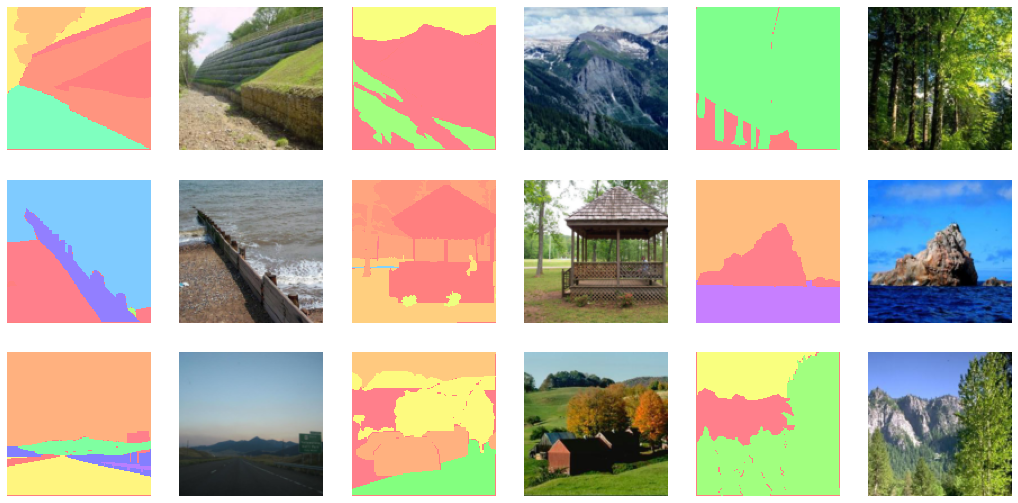

In [ ]:
dls.show_batch(max_n=9)

In [9]:
max_n = 24
test_batch = list(dls.one_batch())
for i in range(len(test_batch)):
  test_batch[i] = test_batch[i][:max_n]

In [ ]:
#for i in range(test_batch[1].shape[0]):
#  torch.argmax(test_batch[1][i], dim=0).show()

In [10]:
record = 'record4'
cbs = GANEvolutionRecorder(storege_path=os.path.join(save_to, record), test_batch=test_batch, plot_fn=plot_record_fn)

In [11]:
gen = Generator(im_size, nz, ngf, class_n, embedding_dim=embedding_dim, norm_type=gen_norm)
#dis = Discriminator(ndf, dis_layers, class_n)
dis_arch = partial(Discriminator, ndf, dis_layers, class_n, norm_type=dis_norm)
dis = MultiScaleDiscriminator(dis_arch, 2)
switcher = FixedGANSwitcher(n_crit=1, n_gen=1)

opt_func = partial(Adam, mom=0.5, sqr_mom=0.999)
perceptual_loss = PerceptualLoss.from_VGG19().cuda()
cbs = [AddPerceptualLoss(perceptual_loss), cbs]
learn = GANLearner_modified(dls, gen, dis, gen_hinge_loss, dis_hinge_loss, lr=lr, prepare_crit_batch_func=add_mask, switcher=switcher, cbs=cbs, opt_func=opt_func)

learn.recorder.train_metrics=True
learn.recorder.valid_metrics=False

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
# dis

In [ ]:
#gen

In [ ]:
learn.fit(100, lr)

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,gen_loss,crit_loss,time
0,1.512121,-0.011772,2.058166,04:08
1,1.539121,-0.038641,1.956048,03:57
2,1.572575,0.035449,1.945952,03:57
3,1.567865,0.051423,1.967945,03:57
4,1.537478,0.012247,1.965313,03:57
5,1.541919,0.030600,1.981727,03:57
6,1.537918,0.082347,1.960113,03:57
7,1.514217,0.047223,1.980718,03:57
8,1.539365,0.043445,1.965557,03:58
9,1.546881,0.051660,1.954236,03:57


/usr/local/lib/python3.7/dist-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [ ]:
# learn.save(os.path.join(save_to, '100 epoch'), with_opt=True)

Path('/content/drive/MyDrive/SPADE/3/100 epoch.pth')

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


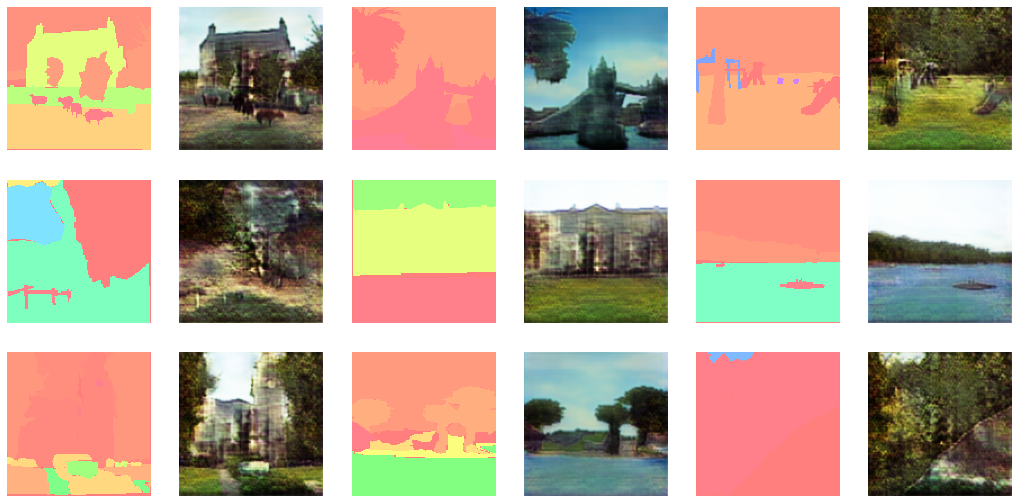

In [ ]:
learn.show_results(max_n=9, ds_idx=0)

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


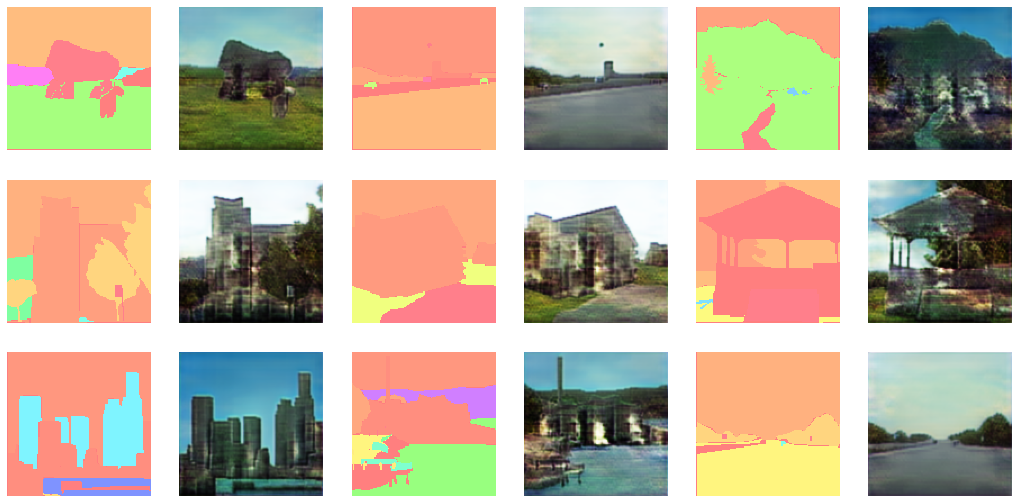

In [ ]:
learn.show_results(max_n=9, ds_idx=0)

In [ ]:
learn.load(os.path.join(save_to, '100 epoch'))

In [ ]:
learn.fit(100, lr)

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,gen_loss,crit_loss,time
0,1.496379,0.072078,1.893456,03:53
1,1.499208,0.039652,1.891119,03:43
2,1.500405,0.113154,1.863292,03:43
3,1.532817,0.104166,1.912412,03:43
4,1.514674,0.089207,1.873690,03:43
5,1.540199,0.156077,1.896527,03:43
6,1.502412,0.049153,1.909554,03:43
7,1.524706,0.113890,1.875995,03:43
8,1.543225,0.142573,1.929730,03:43
9,1.532169,0.135575,1.910310,03:43


/usr/local/lib/python3.7/dist-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [ ]:
learn.save(os.path.join(save_to, '200 epoch'), with_opt=True)

Path('/content/drive/MyDrive/SPADE/3/200 epoch.pth')

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


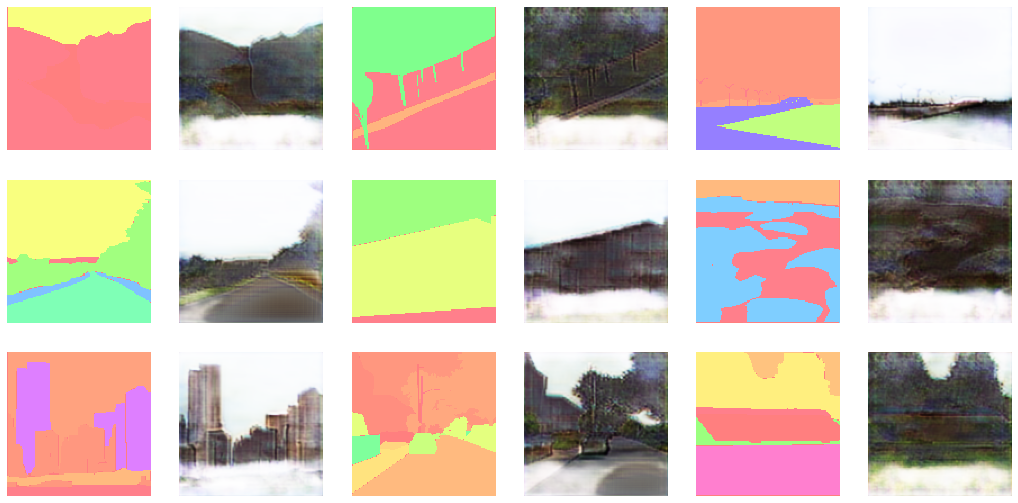

In [ ]:
learn.show_results(max_n=9, ds_idx=0)

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


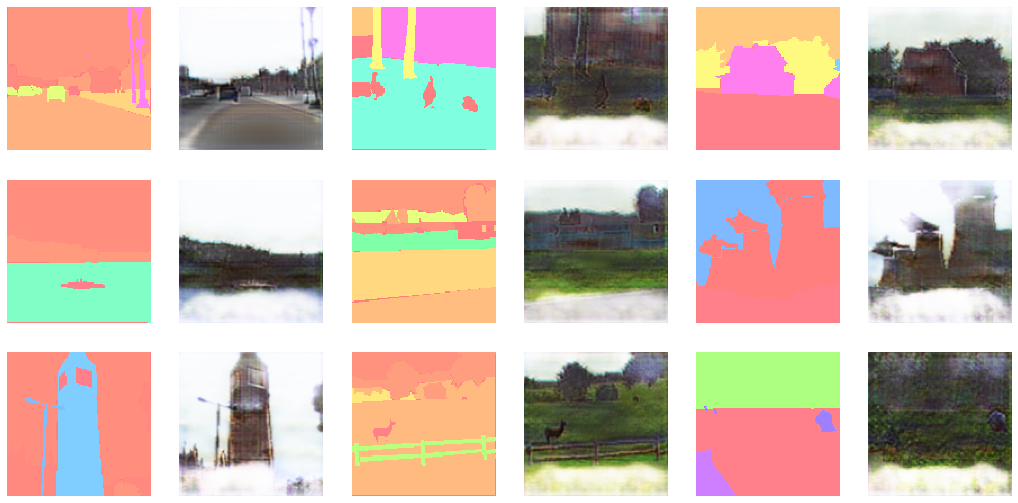

In [ ]:
learn.show_results(max_n=9, ds_idx=0)

In [ ]:
learn.load(os.path.join(save_to, '200 epoch'))

In [ ]:
#sched = {'lr': SchedExp(start=lr, end=lr/20)} for 200 epoch
sched = {'lr': SchedExpPart(start=lr, end=lr/20, start_part=0.0, end_part=0.5)}
learn.fit(100, cbs=ParamScheduler(sched))

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,gen_loss,crit_loss,time
0,1.373484,0.009270,1.698879,03:50
1,1.480573,0.085208,1.755399,03:40
2,1.386684,0.003358,1.638966,03:40
3,1.415118,0.073470,1.683048,03:40
4,1.380911,-0.154048,1.691969,03:40
5,1.394490,0.028780,1.682488,03:41
6,1.450476,0.141860,1.694545,03:40
7,1.374550,-0.047142,1.634700,03:41
8,1.428975,0.092041,1.729390,03:40
9,1.341459,-0.071920,1.654124,03:40


/usr/local/lib/python3.7/dist-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [ ]:
#learn.save(os.path.join(save_to, '300 epoch'), with_opt=True)

Path('/content/drive/MyDrive/SPADE/3/300 epoch.pth')

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


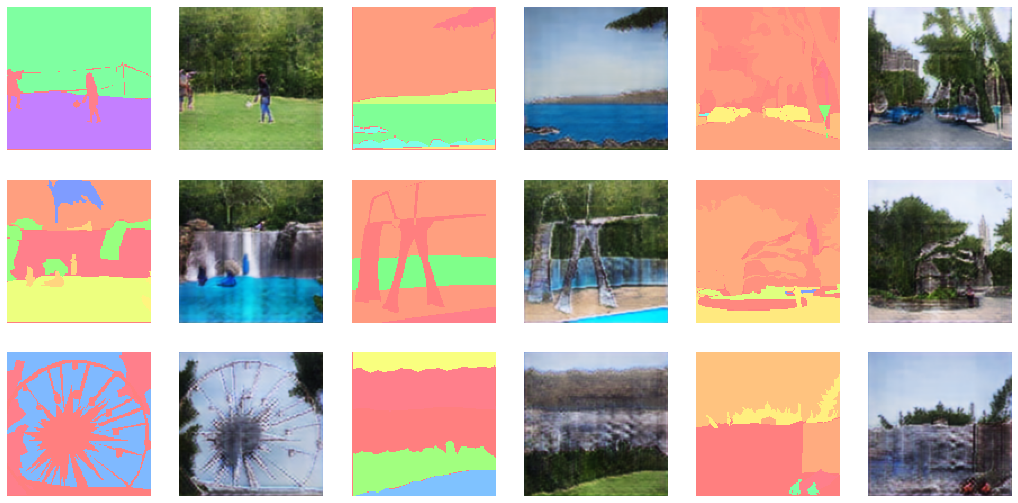

In [ ]:
learn.show_results(max_n=9, ds_idx=0)

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


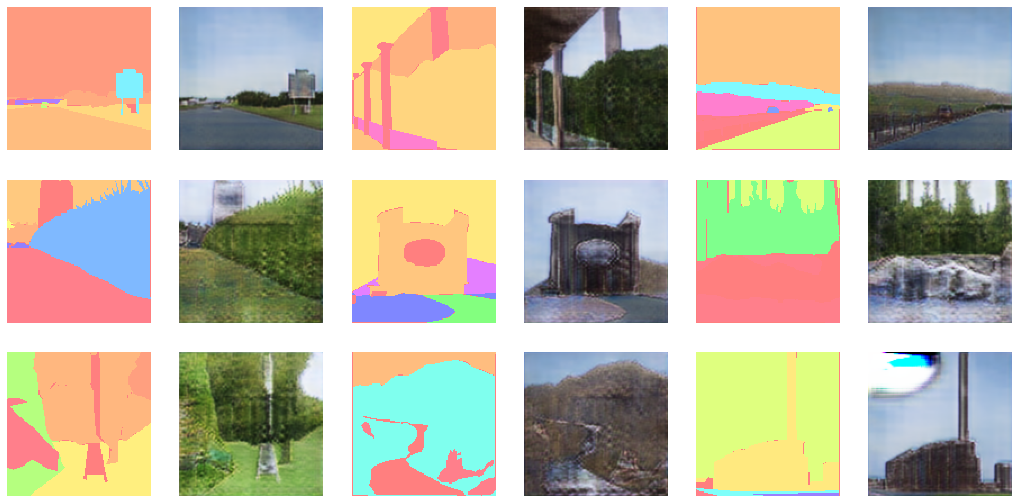

In [ ]:
learn.show_results(max_n=9, ds_idx=0)

In [12]:
learn.load(os.path.join(save_to, '300 epoch'))

In [ ]:
sched = {'lr': SchedExpPart(start=lr, end=lr/20, start_part=0.5, end_part=1.0)}
learn.fit(100, cbs=ParamScheduler(sched))

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,gen_loss,crit_loss,time
0,1.422639,0.229340,1.598624,04:09
1,1.203955,-0.002139,1.407690,03:58
2,1.296360,0.068615,1.413374,03:58
3,1.365790,0.064760,1.586994,03:58
4,1.390887,0.007104,1.390873,03:58
5,1.272845,0.062540,1.458708,03:58
6,1.244433,-0.104945,1.412050,03:57
7,1.402587,0.206803,1.488898,03:58
8,1.361056,0.192152,1.450163,03:58
9,1.268823,0.208076,1.256386,03:58


/usr/local/lib/python3.7/dist-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [ ]:
learn.save(oslearn.show_results(max_n=9, ds_idx=0).path.join(save_to, '400 epoch'), with_opt=True)

In [ ]:
learn.show_results(max_n=9, ds_idx=0)

In [ ]:
learn.show_results(max_n=9, ds_idx=0)